In [1]:
import pandas as pd
import numpy as np
import time
import math
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as Data
from tqdm.notebook import tqdm

train = pd.read_csv('../task2/HS300V2_clean_data/clean_train.csv')
test = pd.read_csv('../task2/HS300V2_clean_data/clean_test.csv')

In [2]:
# timer function
def timeSince(since):
    now = time.time()
    s = now-since
    m = math.floor(s/60)
    s-= m*60
    return '%dm %ds' % (m,s)

In [9]:
# design LASSO network
class LASSO(nn.Module):
    def __init__(self,input_size):
        super(LASSO,self).__init__()
        
        self.fc1 = nn.Linear(input_size,1)
        
    def forward(self,inputs):
        
        outputs = self.fc1(inputs)
        outputs = torch.tanh(outputs)
        
        return outputs


In [10]:
# 95% data as a training set, 5% of data as a validation set
num = len(list(set(train['trade_date'])))
split_date = math.floor(num*0.95)+1215

In [11]:
train_X = train[train['trade_date']<=split_date].iloc[:,3:]
train_y = train[train['trade_date']<=split_date].iloc[:,2]
valid_X = train[train['trade_date']>split_date].iloc[:,3:]
valid_y = train[train['trade_date']>split_date].iloc[:,2]
test_X = test.iloc[:,2:]

In [12]:
# Convert dataframe to tensor 
train_X = torch.tensor(np.array(train_X),dtype=torch.float32)
train_y = torch.tensor(np.array(train_y),dtype=torch.float32)
valid_X = torch.tensor(np.array(valid_X),dtype=torch.float32)
valid_y = torch.tensor(np.array(valid_y),dtype=torch.float32)
test_X = torch.tensor(np.array(test_X),dtype=torch.float32)

In [13]:
# check the shape of the data
print(train_X.shape,valid_X.shape,test_X.shape)
print(train_y.shape,valid_y.shape)

torch.Size([597174, 282]) torch.Size([31818, 282]) torch.Size([108189, 282])
torch.Size([597174]) torch.Size([31818])


In [132]:
inputs_size = train_X.shape[1]
epochs = 2
learning_rate = 1e-4
batch_size = 512
# 正则化项的超参数
lamda = 0.005

In [133]:
train_dataset = Data.TensorDataset(train_X,train_y)
valid_dataset = Data.TensorDataset(valid_X,valid_y)
train_loader = Data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
valid_loader = Data.DataLoader(dataset=valid_dataset,batch_size=batch_size,shuffle=False)

In [158]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
model = LASSO(inputs_size).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.MSELoss().to(device)
regularization = nn.L1Loss(reduction='mean')

In [159]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

283

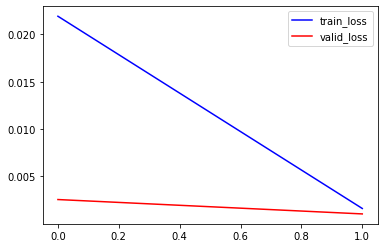

In [160]:
start = time.time()
train_loss = []
valid_loss = [] 
train_epoch_loss = 0
valid_epoch_loss = 0
for epoch in tqdm(range(epochs)):
    model.train()
    for t_batch_idx,(t_inputs,t_labels) in enumerate(train_loader):
        t_inputs,t_labels = t_inputs.to(device),t_labels.to(device)
        t_pred = model(t_inputs)
        t_loss = criterion(t_pred.squeeze(1),t_labels)
        
        regularization_term=0
        paras = list(model.parameters())
        for num,para in enumerate(paras):
            # Wx+b中权重参数W在参数列表的序号为偶数，偏差参数b在参数列表的序号为奇数
            if num % 2==0:
                regularization_term +=lamda*regularization(para,torch.zeros(para.shape))
        t_loss += regularization_term
        
        optimizer.zero_grad()
        t_loss.backward()
        optimizer.step()
        train_epoch_loss+=t_loss.item()
    
    model.eval()
    for v_batch_idx,(v_inputs,v_labels) in enumerate(valid_loader):
            v_inputs,v_labels = v_inputs.to(device),v_labels.to(device)
            v_pred = model(v_inputs)
            v_loss = criterion(v_pred.squeeze(1),v_labels)
            v_loss +=regularization_term
            valid_epoch_loss+=v_loss.item()
            
    
    train_loss.append(train_epoch_loss/(t_batch_idx+1))   
    valid_loss.append(valid_epoch_loss/(v_batch_idx+1))
    train_epoch_loss = 0
    valid_epoch_loss = 0 

    
plt.figure()
plt.plot(train_loss,'b-',label='train_loss')
plt.plot(valid_loss,'r-',label='valid_loss')
plt.legend()
plt.show() 

In [161]:
test_y = model.cpu()(test_X).detach().numpy()
pred = []
for i in range(test_y.shape[0]):
     pred.append([str(test.iloc[i,1]),str(test.iloc[i,0]),str(test_y[i][0])])

In [162]:
pred

[['3402', '0', '-0.03330951'],
 ['3402', '1', '-0.019348267'],
 ['3402', '51', '-0.00063751417'],
 ['3402', '55', '-0.021070935'],
 ['3402', '63', '-0.005968446'],
 ['3402', '69', '-0.038891952'],
 ['3402', '72', '-0.012505565'],
 ['3402', '74', '-0.024111504'],
 ['3402', '75', '-0.0018166327'],
 ['3402', '78', '-0.025783768'],
 ['3402', '83', '-0.008945573'],
 ['3402', '87', '-0.0047216546'],
 ['3402', '88', '-0.04061397'],
 ['3402', '96', '-0.05649201'],
 ['3402', '97', '-0.019953657'],
 ['3402', '106', '-0.021278175'],
 ['3402', '139', '0.0025826064'],
 ['3402', '153', '-0.012769555'],
 ['3402', '167', '-0.021395445'],
 ['3402', '214', '-0.02121971'],
 ['3402', '216', '-0.03247227'],
 ['3402', '219', '-0.027568871'],
 ['3402', '229', '-0.057178304'],
 ['3402', '235', '-0.0078166565'],
 ['3402', '244', '-0.052659456'],
 ['3402', '270', '-0.019220755'],
 ['3402', '274', '-0.022063026'],
 ['3402', '288', '-0.026435101'],
 ['3402', '291', '-0.028051224'],
 ['3402', '318', '-0.041347187'

In [163]:
from BenchmarkTestTool import submit_benchmark_test

data = pred
submitter = "qiuyuan"
dataset = "HS300V2"
comment = 'Lasso'
submit_benchmark_test(submitter,data,dataset,comment,submit=False)

TEST STATUS: success
************************************************************
COMPLETENESS CHECK
************************************************************
average_daily_miss_num:  1
max_miss_day:  3763
max_miss_day_num:  4
max_miss_stock:  3337
max_miss_stock_num:  16
pred_miss_num:  38
pred_miss_ratio:  0.0004
pred_num:  108189
true_num:  108227

************************************************************
SUBMIT SIGNAL PERFORMANCE
************************************************************
autocorrelation:  0.7140340915563729
comment:  Lasso
dataset:  HS300V2
pearson:  0.00206609713578116
pearson_250:  0.013259945775100465
pearson_decay:  0.0001597172305687274
pearson_std:  0.07628404938894119
sid:  903d6c992a3b0c2dc70451c4fc561953
spearman:  -0.0016472692795032082
submit_time:  2021-05-12 07:20:02.304750
submitter:  qiuyuan
top30_win_rate:  0.4759668508287293

************************************************************
MODEL SCORE'S EXPOSURE ON RISKS AND INDUSTRIAL FACTORS 